# Sample code of Image Classification VGG16 Model with PyTorch

This notebook is the sample code of training the image classification model using COCO2014 dataset.  
COCO2014 dataset has not classification labels, therefore it makes classification dataset cropping bounding boxes.

In [1]:
import cv2
import json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from PIL import Image

In [2]:
tqdm.pandas()

## Preparing Dataset

### Download and Extract

In [3]:
DATASET_DIR = '/tmp/dataset'
!ls {DATASET_DIR}

PennFudanPed	  annotations_trainval2014.zip	food-101	 train2014.zip
PennFudanPed.zip  cifar-10-batches-py		food-101.tar.gz  val2014
annotations	  cifar-10-python.tar.gz	train2014	 val2014.zip


In [4]:
if (not Path(DATASET_DIR, 'train2014.zip').exists()):
    !wget http://images.cocodataset.org/zips/train2014.zip -P {DATASET_DIR}
if (not Path(DATASET_DIR, 'val2014.zip').exists()):
    !wget http://images.cocodataset.org/zips/val2014.zip -P {DATASET_DIR}
if (not Path(DATASET_DIR, 'annotations_trainval2014.zip').exists()):
    !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P {DATASET_DIR}
!ls {DATASET_DIR}

PennFudanPed	  annotations_trainval2014.zip	food-101	 train2014.zip
PennFudanPed.zip  cifar-10-batches-py		food-101.tar.gz  val2014
annotations	  cifar-10-python.tar.gz	train2014	 val2014.zip


In [5]:
if (not Path(DATASET_DIR, 'train2014').exists()):
    !unzip -q {DATASET_DIR}/train2014.zip -d {DATASET_DIR}
if (not Path(DATASET_DIR, 'val2014').exists()):
    !unzip -q {DATASET_DIR}/val2014.zip -d {DATASET_DIR}
if (not Path(DATASET_DIR, 'annotations').exists()):
    !unzip -q {DATASET_DIR}/annotations_trainval2014.zip -d {DATASET_DIR}
!ls {DATASET_DIR}

PennFudanPed	  annotations_trainval2014.zip	food-101	 train2014.zip
PennFudanPed.zip  cifar-10-batches-py		food-101.tar.gz  val2014
annotations	  cifar-10-python.tar.gz	train2014	 val2014.zip


### Load annotations

In [6]:
with open(f'{DATASET_DIR}/annotations/instances_train2014.json', 'r') as f:
    instances_train2014 = json.load(f)
with open(f'{DATASET_DIR}/annotations/instances_val2014.json', 'r') as f:
    instances_val2014 = json.load(f)

In [7]:
instances_train2014.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [8]:
df_train2014_images = pd.DataFrame(instances_train2014['images'])
df_train2014_images

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,5,COCO_train2014_000000057870.jpg,http://images.cocodataset.org/train2014/COCO_t...,480,640,2013-11-14 16:28:13,http://farm4.staticflickr.com/3153/2970773875_...,57870
1,5,COCO_train2014_000000384029.jpg,http://images.cocodataset.org/train2014/COCO_t...,429,640,2013-11-14 16:29:45,http://farm3.staticflickr.com/2422/3577229611_...,384029
2,1,COCO_train2014_000000222016.jpg,http://images.cocodataset.org/train2014/COCO_t...,640,480,2013-11-14 16:37:59,http://farm2.staticflickr.com/1431/1118526611_...,222016
3,3,COCO_train2014_000000520950.jpg,http://images.cocodataset.org/train2014/COCO_t...,427,640,2013-11-14 16:44:40,http://farm8.staticflickr.com/7007/6413705793_...,520950
4,4,COCO_train2014_000000069675.jpg,http://images.cocodataset.org/train2014/COCO_t...,480,640,2013-11-14 16:46:33,http://farm8.staticflickr.com/7156/6415223357_...,69675
...,...,...,...,...,...,...,...,...
82778,1,COCO_train2014_000000444010.jpg,http://images.cocodataset.org/train2014/COCO_t...,480,640,2013-11-25 14:46:11,http://farm4.staticflickr.com/3697/9303670993_...,444010
82779,3,COCO_train2014_000000565004.jpg,http://images.cocodataset.org/train2014/COCO_t...,427,640,2013-11-25 19:59:30,http://farm2.staticflickr.com/1278/4677568591_...,565004
82780,3,COCO_train2014_000000516168.jpg,http://images.cocodataset.org/train2014/COCO_t...,480,640,2013-11-25 21:03:34,http://farm3.staticflickr.com/2379/2293730995_...,516168
82781,4,COCO_train2014_000000547503.jpg,http://images.cocodataset.org/train2014/COCO_t...,375,500,2013-11-25 21:20:21,http://farm1.staticflickr.com/178/423174638_1c...,547503


In [9]:
df_train2014_categories = pd.DataFrame(instances_train2014['categories'])
df_train2014_categories

,supercategory,id,name
0,person,1,person
1,vehicle,2,bicycle
2,vehicle,3,car
3,vehicle,4,motorcycle
4,vehicle,5,airplane
...,...,...,...
75,indoor,86,vase
76,indoor,87,scissors
77,indoor,88,teddy bear
78,indoor,89,hair drier


In [10]:
df_train2014_annotations = pd.DataFrame(instances_train2014['annotations'])
df_train2014_annotations

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[312.29, 562.89, 402.25, 511.49, 400.96, 425....",54652.95560,0,480023,"[116.95, 305.86, 285.3, 266.03]",58,86
1,"[[252.46, 208.17, 267.96, 210.11, 280.14, 213....",421.47275,0,50518,"[245.54, 208.17, 40.14, 19.1]",58,89
2,"[[292.92, 25.6, 288.4, 41.42, 289.91, 61.75, 2...",53535.29025,0,142589,"[288.4, 18.07, 211.6, 331.33]",58,93
3,"[[130.29, 506.97, 126.5, 499.87, 133.13, 494.1...",3892.37640,0,209263,"[126.5, 475.24, 77.68, 76.73]",58,113
4,"[[294.94, 115.52, 255.61, 135.18, 228.58, 163....",72576.18295,0,15307,"[185.57, 93.4, 219.97, 420.29]",58,116
...,...,...,...,...,...,...,...
604902,"{'counts': [13254, 1, 316, 4, 6, 1, 315, 7, 31...",4227.00000,1,390883,"[40, 104, 394, 43]",1,900100390883
604903,"{'counts': [68786, 6, 492, 9, 494, 7, 497, 4, ...",6058.00000,1,49902,"[137, 195, 140, 138]",53,905300049902
604904,"{'counts': [203528, 6, 420, 8, 418, 10, 416, 1...",737.00000,1,363764,"[476, 200, 153, 85]",43,904300363764
604905,"{'counts': [99015, 6, 352, 8, 350, 9, 322, 11,...",6478.00000,1,554743,"[275, 207, 153, 148]",1,900100554743


In [11]:
image_id = df_train2014_annotations.iloc[0]['image_id']
bbox = df_train2014_annotations.iloc[0]['bbox']    # XYWH
category_id = df_train2014_annotations.iloc[0]['category_id']
supercategory = df_train2014_categories[df_train2014_categories['id']==category_id].iloc[0]['supercategory']
category_name = df_train2014_categories[df_train2014_categories['id']==category_id].iloc[0]['name']
image_file = df_train2014_images[df_train2014_images['id']==image_id].iloc[0]['file_name']

print(f'{image_id=}')
print(f'{bbox=}')
print(f'{category_id=}')
print(f'{supercategory=}')
print(f'{category_name=}')
print(f'{image_file=}')

image_id=480023
bbox=[116.95, 305.86, 285.3, 266.03]
category_id=58
supercategory='food'
category_name='hot dog'
image_file='COCO_train2014_000000480023.jpg'


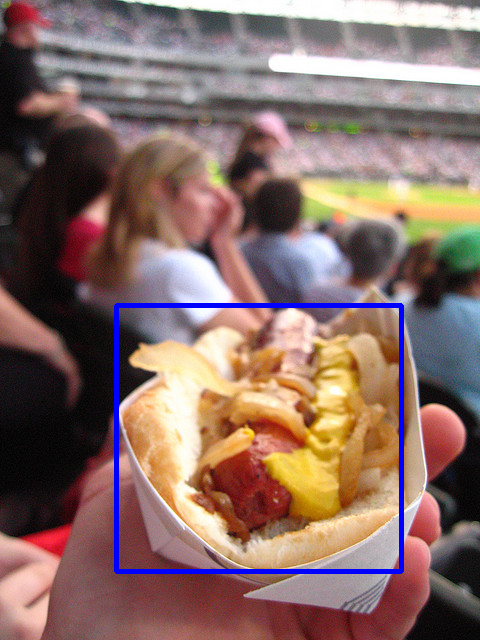

In [12]:
image_path = f'{DATASET_DIR}/train2014/{image_file}'
image = cv2.imread(image_path)
pt1 = np.array(bbox[0:2], dtype=int)
pt2 = np.array(bbox[0:2], dtype=int) + np.array(bbox[2:4], dtype=int)
image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), thickness=3)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
image.show()

In [13]:
image_file = df_train2014_images.iloc[0]['file_name']
image_id = df_train2014_images.iloc[0]['id']

print(f'{image_file=}')
print(f'{image_id=}')

image_file='COCO_train2014_000000057870.jpg'
image_id=57870


In [14]:
def extract_object(x, df_images):
    bbox = x['bbox']
    image_id = x['image_id']
    category_id = x['category_id']

    image = df_images[df_images['id']==image_id]

    input = image['file_name'].iloc[0]
    target = category_id
    return pd.Series([input, target])

In [15]:
df_new = pd.DataFrame()
df_new[['input_file', 'target']] = df_train2014_annotations[:1000].progress_apply(extract_object, df_images=df_train2014_images, axis=1)
df_new

100% 1000/1000 [00:01<00:00, 671.49it/s]


,input_file,target
0,COCO_train2014_000000480023.jpg,58
1,COCO_train2014_000000050518.jpg,58
2,COCO_train2014_000000142589.jpg,58
3,COCO_train2014_000000209263.jpg,58
4,COCO_train2014_000000015307.jpg,58
...,...,...
995,COCO_train2014_000000295931.jpg,18
996,COCO_train2014_000000301479.jpg,18
997,COCO_train2014_000000127284.jpg,18
998,COCO_train2014_000000243051.jpg,18
